In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!kaggle datasets download -d requiemonk/sentinel12-image-pairs-segregated-by-terrain

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
%%capture
!unzip sentinel12-image-pairs-segregated-by-terrain.zip
!rm -rf sentinel12-image-pairs-segregated-by-terrain.zip

In [1]:
import os
import shutil
import zipfile # Import zipfile module

opt = []
sar = []
root_dir = './v_2'

# Unzip v_2.zip if it exists
if os.path.exists('v_2.zip'):
    with zipfile.ZipFile('v_2.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("v_2.zip extracted successfully!")
else:
    print("v_2.zip not found. Please make sure it is in the current directory.")


if not os.path.exists(root_dir):
    print(f"Error: Directory '{root_dir}' not found.")
    # If you know the correct path, replace it here:
    # root_dir = "your/correct/path"
    # print(f"Using '{root_dir}' instead.")
else:
    for dir in os.listdir(root_dir):
        path = os.path.join(root_dir, dir)
        s1, s2 = os.listdir(path)
        if s1 == 's2':
            for file in os.listdir(os.path.join(path, s1)):
                if file.endswith('.png'):
                    opt.append(os.path.join(path, s1, file))
            for file in os.listdir(os.path.join(path, s2)):
                if file.endswith('.png'):
                    sar.append(os.path.join(path, s2, file))
        if s1 == 's1':
            for file in os.listdir(os.path.join(path, s1)):
                if file.endswith('.png'):
                    sar.append(os.path.join(path, s1, file))
            for file in os.listdir(os.path.join(path, s2)):
                if file.endswith('.png'):
                    opt.append(os.path.join(path, s2, file))
    opt = sorted(opt)
    sar = sorted(sar)
    print(len(opt), len(sar))

v_2.zip not found. Please make sure it is in the current directory.
Error: Directory './v_2' not found.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from skimage import util
import numpy as np
from PIL import Image

class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(1, n_channels, kernel_size=3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(n_channels, 1, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)

In [ ]:
# Dataset Class for Noisy/Clean Image Pairs
class SARImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.sar = clean_images[0]
        self.opt = clean_images[1]
        self.transform = transform

    def __len__(self):
        return len(self.sar)

    def __getitem__(self, idx):
        sar_img = self.sar[idx]
        opt_img = self.opt[idx]
        noisy_img = np.array(Image.open(sar_img).convert('L'))
        img = np.array(Image.open(opt_img).convert('L'))
        if self.transform:
            img = self.transform(img)
            noisy_img = self.transform(noisy_img)
        return noisy_img, img

# Load and preprocess data
images = [sar[:10000], opt[:10000]]
dataset = SARImageDataset(images, transform=ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
from tqdm import tqdm
import torch

# Training the DnCNN Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define device here
model = DnCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def train(model, dataloader, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs} (Training)", unit="batch") as pbar:
            epoch_loss = 0
            for noisy_imgs, clean_imgs in dataloader:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                optimizer.zero_grad()
                denoised_imgs = model(noisy_imgs)
                loss = criterion(denoised_imgs, clean_imgs)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                # Update progress bar
                pbar.set_postfix(loss=f"{epoch_loss/(pbar.n+1):.4f}")
                pbar.update(1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}')

train(model, train_loader)

Epoch 1/15 (Training): 100%|██████████| 1/1 [00:57<00:00, 57.06s/batch, loss=0.2024]


Epoch [1/15], Loss: 0.2024


Epoch 2/15 (Training): 100%|██████████| 1/1 [00:56<00:00, 56.25s/batch, loss=0.2172]


Epoch [2/15], Loss: 0.2172


Epoch 3/15 (Training): 100%|██████████| 1/1 [00:57<00:00, 57.43s/batch, loss=0.3160]


Epoch [3/15], Loss: 0.3160


Epoch 4/15 (Training): 100%|██████████| 1/1 [01:00<00:00, 60.17s/batch, loss=0.0976]


Epoch [4/15], Loss: 0.0976


Epoch 5/15 (Training): 100%|██████████| 1/1 [00:58<00:00, 58.02s/batch, loss=0.0977]


Epoch [5/15], Loss: 0.0977


Epoch 6/15 (Training): 100%|██████████| 1/1 [01:01<00:00, 61.87s/batch, loss=0.0721]


Epoch [6/15], Loss: 0.0721


Epoch 7/15 (Training): 100%|██████████| 1/1 [01:01<00:00, 61.50s/batch, loss=0.0561]


Epoch [7/15], Loss: 0.0561


Epoch 8/15 (Training): 100%|██████████| 1/1 [00:58<00:00, 58.61s/batch, loss=0.0505]


Epoch [8/15], Loss: 0.0505


Epoch 9/15 (Training): 100%|██████████| 1/1 [00:58<00:00, 58.42s/batch, loss=0.0461]


Epoch [9/15], Loss: 0.0461


Epoch 10/15 (Training): 100%|██████████| 1/1 [00:56<00:00, 56.35s/batch, loss=0.0443]


Epoch [10/15], Loss: 0.0443


Epoch 11/15 (Training): 100%|██████████| 1/1 [00:57<00:00, 57.11s/batch, loss=0.0429]


Epoch [11/15], Loss: 0.0429


Epoch 12/15 (Training): 100%|██████████| 1/1 [00:56<00:00, 56.73s/batch, loss=0.0423]


Epoch [12/15], Loss: 0.0423


Epoch 13/15 (Training): 100%|██████████| 1/1 [00:58<00:00, 58.50s/batch, loss=0.0430]


Epoch [13/15], Loss: 0.0430


Epoch 14/15 (Training): 100%|██████████| 1/1 [00:57<00:00, 57.54s/batch, loss=0.0445]


Epoch [14/15], Loss: 0.0445


Epoch 15/15 (Training): 100%|██████████| 1/1 [00:58<00:00, 58.40s/batch, loss=0.0444]

Epoch [15/15], Loss: 0.0444


In [ ]:
torch.save(model, 'dcnn.pth')

In [ ]:
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Evaulating the denoising model
def test_accuracy(model, test_dataloader):
    total_psnr = 0
    total_ssim = 0
    num_images = 0
    model.eval()

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(test_dataloader, desc="Evaluating"): # Add description to tqdm
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            denoised_imgs = model(noisy_imgs)

            denoised_imgs = denoised_imgs.cpu().numpy()
            clean_imgs = clean_imgs.cpu().numpy()

            # Iterate over the batch
            for i in range(clean_imgs.shape[0]):
                psnr = peak_signal_noise_ratio(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)
                ssim = structural_similarity(clean_imgs[i, 0], denoised_imgs[i, 0], data_range=1.0)

                total_psnr += psnr
                total_ssim += ssim
                num_images += 1

    # Check if num_images is 0 before division
    if num_images == 0:
        print("Warning: No images were processed. Returning 0 for PSNR and SSIM.")
        return 0, 0  # Or any other suitable default values
    else:
        avg_psnr = total_psnr / num_images
        avg_ssim = total_ssim / num_images

        print(f'Average PSNR: {avg_psnr:.2f} dB') # Print PSNR here
        print(f'Average SSIM: {avg_ssim:.4f}') # Print SSIM here

        return avg_psnr, avg_ssim

In [ ]:
# Calculate PSNR and SSIM on the test set
avg_psnr, avg_ssim = test_accuracy(model, test_dataloader)
print(f'Average PSNR: {avg_psnr:.2f} dB')
print(f'Average SSIM: {avg_ssim:.4f}')

Evaluating: 0it [00:00, ?it/s]

Average PSNR: 0.00 dB
Average SSIM: 0.0000


In [ ]:
denoise_model = torch.load('dcnn.pth', map_location=device)


<ipython-input-22-aaf61fe9bf9d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoise_model = torch.load('dcnn.pth', map_location=device)


In [ ]:
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

def prediction(model, sar_images):
    model.eval()
    predictedimages = []
    with torch.no_grad():
        for noisy_imgs in tqdm(sar_images):
            noisy_imgs = np.array(Image.open(noisy_imgs).convert('L'))
            noisy_imgs = transforms.ToTensor()(noisy_imgs)
            noisy_imgs = noisy_imgs.unsqueeze(0).to(device)
            denoised_imgs = model(noisy_imgs)
            img = denoised_imgs.squeeze(0).cpu().numpy()
            img = (img[0] * 255).astype('uint8')
            predictedimages.append(img)
    return predictedimages

gray_images = prediction(denoise_model, sar)

100%|██████████| 18/18 [00:42<00:00,  2.37s/it]


array([[106, 102,  82, ..., 249,   2,  68],
       [ 72,  67,  66, ..., 238, 245,  32],
       [ 57,  48,  61, ..., 242, 251,  24],
       ...,
       [ 84,  77,  63, ...,  70,  69, 102],
       [ 37,  40,  30, ...,  46,  74,  93],
       [ 15,  35,  32, ...,  63,  93, 111]], dtype=uint8)
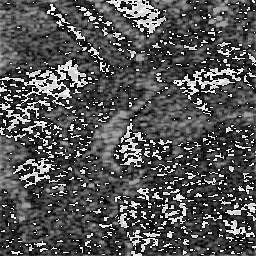

In [ ]:
gray_images[2]

In [ ]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

def rgb_to_lab(img):

    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)
    L_channel = img_lab[[0], ...]
    ab_channels = img_lab[[1, 2], ...]
    # scale between -1 to 1
    L_channel = 2 * (L_channel - (0)) / (100 - (0)) - 1
    ab_channels = 2 * (ab_channels - (-128)) / (127 - (-128)) - 1

    return L_channel, ab_channels

In [ ]:
def create_patches(img, patch_size=224):
    patches = []
    h, w = img.shape[1:]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                patches.append(patch)

    return patches

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform=None, patch_size=224):
        self.grayscale_dir = grayscale_dir
        self.color_dir = color_dir
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.grayscale_dir)

    def __getitem__(self, idx):

        gray_img = self.grayscale_dir[idx]
        color_img = np.array(Image.open(self.color_dir[idx]))

        # resize image to 224
        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        # Convert to Lab color space
        gray_L, gray_ab = rgb_to_lab(cv2.merge((gray_img, gray_img, gray_img)))
        L_channel, ab_channels = rgb_to_lab(color_img)

        # # convert gray in range of -1 to 1
        gray_img = gray_img / 2.55
        gray_img = (gray_img - (0)) / (100 - (0)) * 2 - 1
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)


        return gray_L, ab_channels

In [ ]:
dataset = ColorizationDataset(gray_images[:10000], opt[:10000])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=False) # Change drop_last to False
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False) # Change drop_last to False
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False) # Change drop_last to False

In [ ]:
# Load a batch and print the shapes of the patches
for L_patches, ab_patches in train_loader:
    print(f"L_patches shape: {L_patches.shape}")
    print(f"ab_patches shape: {ab_patches.shape}")
    print(L_patches[0])
    break

L_patches shape: torch.Size([12, 1, 224, 224])
ab_patches shape: torch.Size([12, 2, 224, 224])
tensor([[[-0.1854,  0.5976, -0.6027,  ...,  0.0560, -0.1607, -0.3279],
         [-0.6027, -0.5568, -0.6872,  ...,  0.2340, -0.1280, -0.1443],
         [-0.3795, -0.2855, -0.4405,  ...,  0.1804, -0.1936, -0.0152],
         ...,
         [ 0.0166, -0.0874, -0.2855,  ..., -0.3795, -0.2603, -0.1280],
         [ 0.0481, -0.1771, -0.3708,  ..., -0.6306, -0.4055,  0.0324],
         [-0.0552, -0.1117, -0.1199,  ..., -0.3622,  0.0007,  0.3698]]])


In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights, DenseNet121_Weights

class EnsembleEncoder(nn.Module):
    def __init__(self):
        super(EnsembleEncoder, self).__init__()

        # Load pre-trained ResNet50 and DenseNet121
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.densenet121 = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        # self.densenet121 = nn.Sequential(*list(self.densenet121.children())[:-1])
        self.densenet121.classifier = nn.Identity()


        # Custom layers for fusion
        self.conv1x1_resnet50 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(2048, 1024, kernel_size=1)
        ])

        self.conv1x1_densenet121 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(1024, 1024, kernel_size=1)
        ])

        self.fusion_blocks = nn.ModuleList([
            self.fusion_block(128, 128),
            self.fusion_block(256, 256),
            self.fusion_block(512, 512),
            self.fusion_block(1024, 1024)
        ])

    # Fusion block
    def fusion_block(self, in_channels_resnet, in_channels_densenet):
        return nn.Sequential(
            nn.Conv2d(in_channels_resnet + in_channels_densenet, in_channels_resnet, kernel_size=1),
            nn.BatchNorm2d(in_channels_resnet),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through ResNet50
        resnet_features = []
        resnet_input = x
        for i, layer in enumerate(self.resnet50.children()):
            resnet_input = layer(resnet_input)
            if i in [4, 5, 6, 7]:  # Extract features after specific layers
                resnet_features.append(self.conv1x1_resnet50[i-4](resnet_input))

        # Forward pass through DenseNet121
        densenet_features = []
        idx = 0
        densenet_input = x
        for i, layer in enumerate(self.densenet121.features):
            densenet_input = layer(densenet_input)
            if i in [ 4, 6, 8, 11]:
                densenet_features.append(self.conv1x1_densenet121[idx](densenet_input))
                idx += 1


        fused_features = []
        for i in range(4):
            fused = torch.cat((resnet_features[i], densenet_features[i]), dim=1)
            fused = self.fusion_blocks[i](fused)
            fused_features.append(fused)

        return fused_features

In [ ]:

import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Decoder block 1: Takes input from Fusion Block 4
        self.decode1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 7x7 -> 14x14
        )

        # Decoder block 2: Takes input from Decoder Block 1 + Fusion Block 3 (512 + 512 channels)
        self.decode2 = nn.Sequential(
            nn.Conv2d(512 + 512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 14x14 -> 28x28
        )

        # Decoder block 3: Takes input from Decoder Block 2 + Fusion Block 2 (256 + 256 channels)
        self.decode3 = nn.Sequential(
            nn.Conv2d(256 + 256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 28x28 -> 56x56
        )

        # Decoder block 4: Takes input from Decoder Block 3 + Fusion Block 1 (128 + 128 channels)
        self.decode4 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 56x56 -> 112x112
        )

        # Final decoder block: Reduce to 2 channels (ab channels)
        self.decode5 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 112x112 -> 224x224
        )

    def forward(self, features_7x7, features_14x14, features_28x28, features_56x56):
        x = self.decode1(features_7x7)
        x = torch.cat([x, features_14x14], dim=1)
        x = self.decode2(x)

        x = torch.cat([x, features_28x28], dim=1)
        x = self.decode3(x)

        x = torch.cat([x, features_56x56], dim=1)
        x = self.decode4(x)

        output = self.decode5(x)

        return output

In [ ]:
import torch
import torch.nn as nn

class ColorizationModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ColorizationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        features_56x56, features_28x28, features_14x14, features_7x7 = self.encoder(x)

        output = self.decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        return output

encoder = EnsembleEncoder()
decoder = Decoder()

model = ColorizationModel(encoder, decoder)

# input data
L_patches = torch.randn(1, 3, 224, 224)

output = model(L_patches)

print("Output shape:", output.shape)  # output shape should be [1, 2, 224, 224]

Output shape: torch.Size([1, 2, 224, 224])


In [ ]:

%%time
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = EnsembleEncoder()
decoder = Decoder()

# Freeze the encoder parameters as they are not to be trained
for param in encoder.parameters():
    param.requires_grad = False


model = ColorizationModel(encoder, decoder).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")

    for i, (L_batch, ab_batch) in enumerate(train_bar):
        L, ab = L_batch.to(device), ab_batch.to(device)
        L = L.repeat(1, 3, 1, 1)

        optimizer.zero_grad()

        output = model(L)

        loss = criterion(output, ab)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_bar.set_postfix(loss=f"{running_loss/(i+1):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")

    with torch.no_grad():
        for i, (L_batch, ab_batch) in enumerate(val_bar):
            L, ab = L_batch.to(device), ab_batch.to(device)
            L = L.repeat(1, 3, 1, 1)

            output = model(L)
            loss = criterion(output, ab)
            val_loss += loss.item()

            val_bar.set_postfix(loss=f"{val_loss/(i+1):.4f}")

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'best_colorization_model.pth')

print("Training complete.")

Epoch 1/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it, loss=0.0136]


Epoch 1/15, Training Loss: 0.1018, Validation Loss: 0.0136


Epoch 2/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it, loss=0.0195]


Epoch 2/15, Training Loss: 0.1692, Validation Loss: 0.0195


Epoch 3/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, loss=0.0103]


Epoch 3/15, Training Loss: 0.3233, Validation Loss: 0.0103


Epoch 4/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it, loss=0.0515]


Epoch 4/15, Training Loss: 0.1365, Validation Loss: 0.0515


Epoch 5/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, loss=0.0899]


Epoch 5/15, Training Loss: 0.0790, Validation Loss: 0.0899


Epoch 6/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it, loss=0.1026]


Epoch 6/15, Training Loss: 0.0536, Validation Loss: 0.1026


Epoch 7/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it, loss=0.0784]


Epoch 7/15, Training Loss: 0.0412, Validation Loss: 0.0784


Epoch 8/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, loss=0.0489]


Epoch 8/15, Training Loss: 0.0250, Validation Loss: 0.0489


Epoch 9/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.96s/it, loss=0.0467]


Epoch 9/15, Training Loss: 0.0216, Validation Loss: 0.0467


Epoch 10/15 (Validation): 100%|██████████| 1/1 [00:02<00:00,  2.22s/it, loss=0.0563]


Epoch 10/15, Training Loss: 0.0236, Validation Loss: 0.0563


Epoch 11/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, loss=0.0751]


Epoch 11/15, Training Loss: 0.0210, Validation Loss: 0.0751


Epoch 12/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, loss=0.0924]


Epoch 12/15, Training Loss: 0.0166, Validation Loss: 0.0924


Epoch 13/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it, loss=0.0935]


Epoch 13/15, Training Loss: 0.0151, Validation Loss: 0.0935


Epoch 14/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it, loss=0.0767]


Epoch 14/15, Training Loss: 0.0144, Validation Loss: 0.0767


Epoch 15/15 (Validation): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, loss=0.0530]

Epoch 15/15, Training Loss: 0.0122, Validation Loss: 0.0530
Training complete.
CPU times: user 2min 35s, sys: 17.1 s, total: 2min 52s
Wall time: 3min 5s


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import rgb2lab

class ColorizationDatasetNew(Dataset):
    def __init__(self, gray_img, opt_image, transform=None):
        self.gray_image = gray_img
        self.opt_image = opt_image
        self.transform = transform

    def __len__(self):
        return len(self.gray_image)

    def __getitem__(self, idx):
        gray_img = self.gray_image[idx]
        color_img = np.array(Image.open(self.opt_image[idx]))

        gray_img = cv2.resize(gray_img, (224, 224))
        color_img = cv2.resize(color_img, (224, 224))

        gray_L, gray_ab = rgb_to_lab(cv2.merge([gray_img, gray_img, gray_img]))
        L_channel, ab_channels = rgb_to_lab(color_img)

        gray_img = gray_img / 2.55
        gray_img = (gray_img - (0)) / (100 - (0)) * 2 - 1
        gray_img = transforms.ToTensor()(gray_img)
        gray_img = gray_img.type(torch.float32)

        return gray_L, L_channel, ab_channels

# Create the test dataset for prediction
dataset_new = ColorizationDatasetNew(gray_images, opt)

test_set_new = DataLoader(dataset_new, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
for L,real_L, ab in test_set_new:
    print(real_L.shape)
    print(L.shape)
    print(ab.shape)
    print(L[0][0])
    break

torch.Size([18, 1, 224, 224])
torch.Size([18, 1, 224, 224])
torch.Size([18, 2, 224, 224])
tensor([[ 0.1030,  0.0403, -0.0232,  ..., -0.0312,  0.0874,  0.2720],
        [ 0.0086,  0.0717, -0.0312,  ..., -0.2435, -0.3109, -0.1199],
        [ 0.0086,  0.0481, -0.0955,  ..., -0.0632, -0.1525,  0.0086],
        ...,
        [-0.3450, -0.3968, -0.2603,  ...,  0.8680,  0.4071,  0.3023],
        [-0.1689, -0.2519, -0.1936,  ...,  0.6481,  0.6553, -0.3795],
        [ 0.0481,  0.0324,  0.0166,  ..., -0.1771, -0.8907, -0.4581]])


In [ ]:
# Get a batch from the test loader
dataiter = iter(test_set_new)
L_batch,real_L, ab_batch = next(dataiter)
L_batch, real_L, ab_batch = L_batch.to(device),real_L.to(device), ab_batch.to(device)
L_batch = L_batch.repeat(1, 3, 1, 1)

model.eval()
with torch.no_grad():
    predicted_ab = model(L_batch)

In [ ]:
predicted_ab[0][0]

tensor([[0.0719, 0.0577, 0.0295,  ..., 0.0041, 0.0299, 0.0428],
        [0.0674, 0.0549, 0.0297,  ..., 0.0230, 0.0576, 0.0748],
        [0.0586, 0.0491, 0.0301,  ..., 0.0607, 0.1128, 0.1389],
        ...,
        [0.0634, 0.0565, 0.0427,  ..., 0.0065, 0.0345, 0.0486],
        [0.0421, 0.0445, 0.0492,  ..., 0.0207, 0.0332, 0.0394],
        [0.0315, 0.0385, 0.0525,  ..., 0.0278, 0.0325, 0.0349]])

In [ ]:
L_batch = L_batch[:, 0, :, :]
L_batch = L_batch.unsqueeze(1)

L_batch = (L_batch + 1) * 0.5 * 100
real_L = (real_L + 1) * 0.5 * 100
predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

# Combine L and ab channels
predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
real_lab = torch.cat([L_batch, ab_batch], dim=1)
actual_lab = torch.cat([real_L, ab_batch], dim=1)

predicted_lab = predicted_lab.cpu().numpy()
real_lab = real_lab.cpu().numpy()
actual_lab = actual_lab.cpu().numpy()

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1595 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


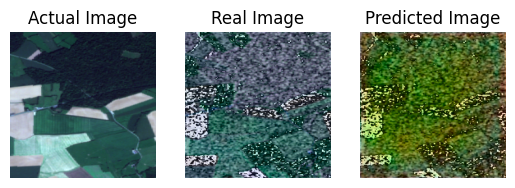

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 653 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


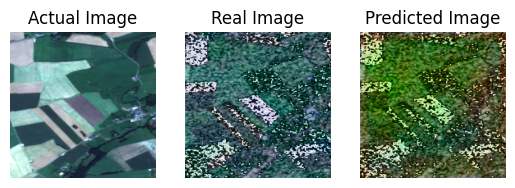

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 669 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


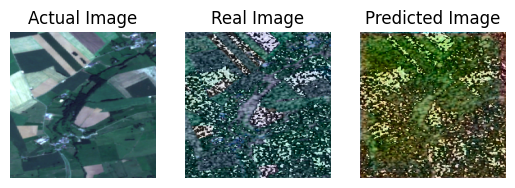

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


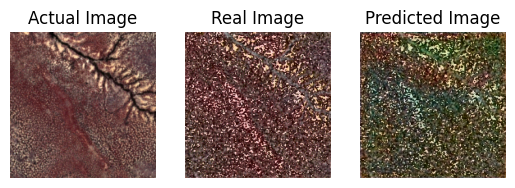

<ipython-input-51-4234e9b95d04>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  real_rgb = lab2rgb(real_img)


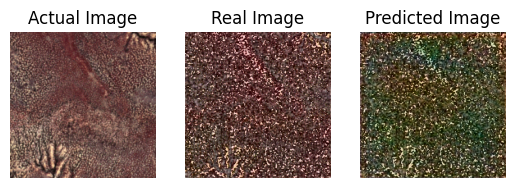

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 76 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


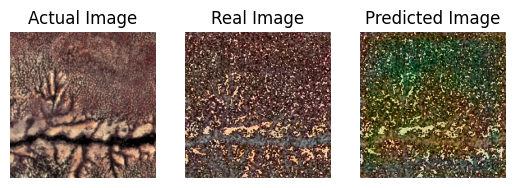

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


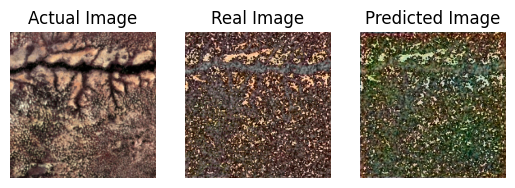

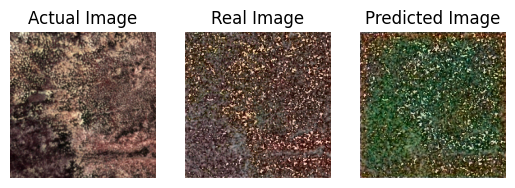

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-51-4234e9b95d04>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 86 negative Z values that have been clipped to zero
  real_rgb = lab2rgb(real_img)


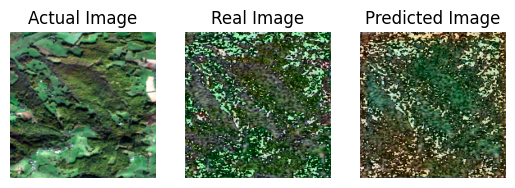

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-51-4234e9b95d04>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 59 negative Z values that have been clipped to zero
  real_rgb = lab2rgb(real_img)


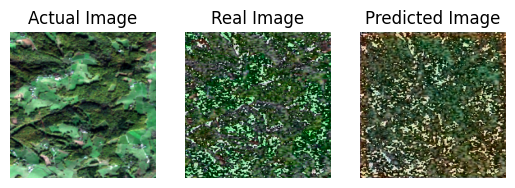

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 210 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-51-4234e9b95d04>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 58 negative Z values that have been clipped to zero
  real_rgb = lab2rgb(real_img)


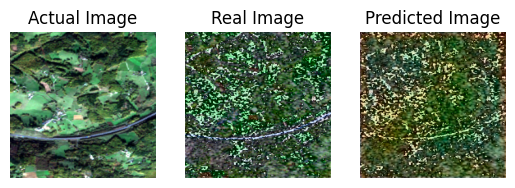

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 41 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-51-4234e9b95d04>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 83 negative Z values that have been clipped to zero
  real_rgb = lab2rgb(real_img)


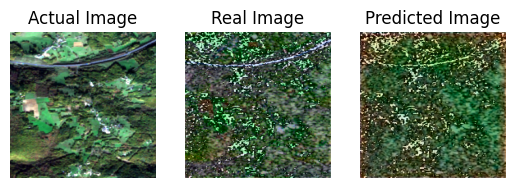

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 19 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-51-4234e9b95d04>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 75 negative Z values that have been clipped to zero
  real_rgb = lab2rgb(real_img)


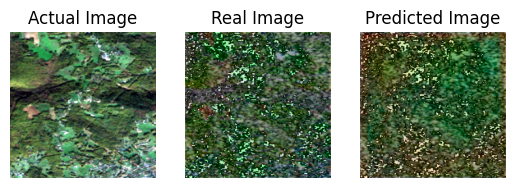

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 27 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


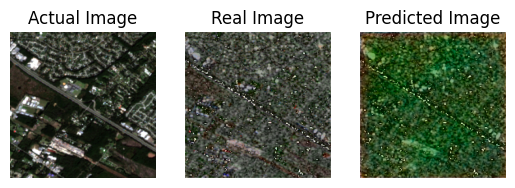

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 78 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


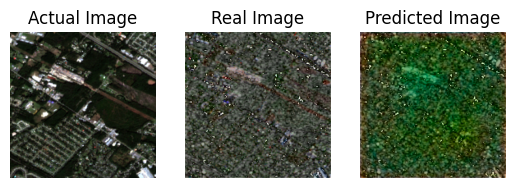

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 180 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


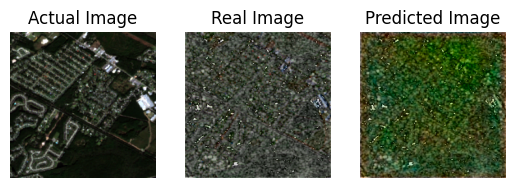

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 253 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)


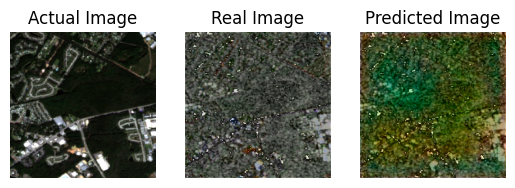

<ipython-input-51-4234e9b95d04>:22: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 667 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image)
<ipython-input-51-4234e9b95d04>:23: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  real_rgb = lab2rgb(real_img)


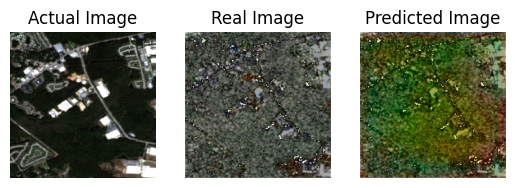

In [ ]:
import numpy as np
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import cv2

# Get the number of images in the batch
num_images = predicted_lab.shape[0]

# Iterate over the batch
for i in range(num_images):  # Use num_images instead of a fixed value

    lab_image = predicted_lab[i]
    real_img = real_lab[i]
    actual_img = actual_lab[i]

    # Transpose to (height, width, 3) for skimage
    lab_image = lab_image.transpose(1, 2, 0)
    real_img = real_img.transpose(1, 2, 0)
    actual_img = actual_img.transpose(1, 2, 0)

    # Convert Lab to RGB using skimage.color.lab2rgb
    rgb_image = lab2rgb(lab_image)
    real_rgb = lab2rgb(real_img)
    actual_rgb = lab2rgb(actual_img)

    plt.subplot(1, 3, 1)
    plt.imshow(actual_rgb)
    plt.axis('off')
    plt.title('Actual Image')
    plt.subplot(1, 3, 2)
    plt.imshow(real_rgb)
    plt.axis('off')
    plt.title('Real Image')
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_image)
    plt.title('Predicted Image')
    plt.axis('off')
    plt.show()